### Modules used in this notebook
`xarray`, `cfgrib`, `cartopy`, `numpy`

# C.004: Creating more complex maps

In [1]:
import numpy as np
import xarray as xr # xarray library access and manipulate multi-dimensional data (such as netcdf). With the cfgrib engine we can manipulate grib files
from matplotlib import pyplot as plt # matplotlib package provides different functions to plot data
import cartopy.crs as ccrs # cartopy package can be integrated with matplotlib to plot georeferenced data
import cartopy.feature

We use xarray to open the dataset, compute the wind speed and the daily mean from hourly data

In [2]:
ds = xr.open_dataset('../data/era5-u100_v100_201903.grib')

ds['ws100'] = (ds['u100']**2 + ds['v100']**2)**0.5

In [3]:
# compute daily mean
ds_daily = ds.resample(time='1D').mean('time')
ds_daily

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 31, latitude: 97, longitude: 129)
Coordinates:
    number     int32 4B 0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0
  * latitude   (latitude) float64 776B 60.0 59.75 59.5 59.25 ... 36.5 36.25 36.0
  * longitude  (longitude) float64 1kB -12.0 -11.75 -11.5 ... 19.5 19.75 20.0
  * time       (time) datetime64[ns] 248B 2019-03-01 2019-03-02 ... 2019-03-31
Data variables:
    u100       (time, latitude, longitude) float32 2MB 0.3079 0.2702 ... 4.226
    v100       (time, latitude, longitude) float32 2MB 9.274 9.326 ... -7.159
    ws100      (time, latitude, longitude) float32 2MB 10.79 10.74 ... 8.489
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-18T21:08 GRIB to CDM+CF via cfgrib-0.9.1...

### Create the map

We use cartopy package that, together with matplotlib, helps plot variables with different projections

All the available projections can be found [here](https://scitools.org.uk/cartopy/docs/v0.13/crs/projections.html#cartopy-projections)


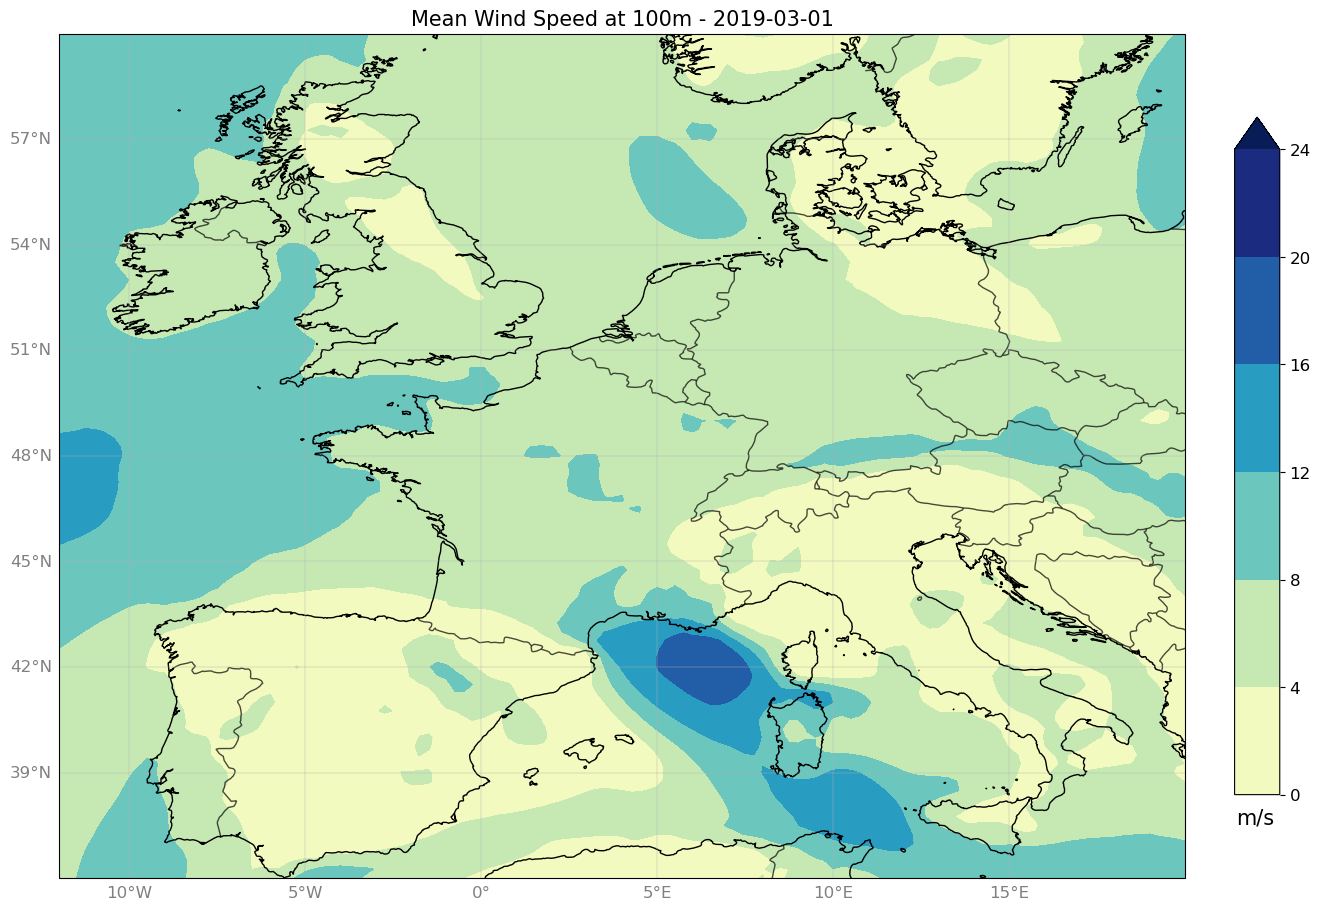

In [4]:
# set the desire countour levels
clevs = np.arange(0, 28, 4)
# create the lat lon grid from the data latitudes and longitudes
lons, lats = np.meshgrid(ds_daily.longitude.values, ds_daily.latitude.values)
# create the figure instance, the top level container of the figure
fig = plt.figure(figsize=(16, 11))
crs_latlon = ccrs.PlateCarree()
# generate the axes which have the projection that we will use
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=0))
# set the limits of the domain relative to the projection
ax.set_extent([-12, 20, 36, 60], crs_latlon)
# filled contours of the magnitude of wind at 10mm for the first date
im=ax.contourf(lons, lats, ds_daily['ws100'].isel(time=0), clevs, transform=crs_latlon,
               cmap='YlGnBu', extend='max')
# uncomment the following line in you want to add contours to the shading
# ax.contour(lons, lats, ds_daily['ws100'].isel(time=0), colors='k', linewidths=0.5,
#           levels=clevs, transform=crs_latlon)
# generate colorbar and place it besides the plot
cbar = plt.colorbar(im, fraction=0.052, pad=0.04, shrink=0.8, aspect=15)
# tune the labels and ticks
cbar.ax.tick_params(labelsize=12)
cbar.set_label('m/s', labelpad=-40, y=-0.02, rotation=0, fontsize=15)
# add coastlines. resolution can be coarser (for instance, 50m)
ax.coastlines(resolution='10m', color='black', linewidth=1)
# add country borders
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.7)
# add gridlines, lat and lon and tune the labels
gl = ax.gridlines(crs=crs_latlon, draw_labels=True, linewidth=0.3, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'gray'}
gl.ylabel_style = {'size': 12, 'color': 'gray'}
# add figure title
ax.set_title('Mean Wind Speed at 100m - ' + str(ds_daily.time[0].values.astype('datetime64[D]')),
             fontsize=15)
# save figure with 300 dpi resolution
plt.savefig('MagU_100m_' + str(ds.time[0].values.astype('datetime64[D]'))+ '.jpg',
            dpi=300, bbox_inches='tight')